<a href="https://colab.research.google.com/github/anuraga-sankepally/Controls/blob/main/Diff_flatness_based_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

# Import Libraries


In [ ]:
from math import cos, sin
import numpy as np
#from CartPole import CartPole
from random import random
import scipy.signal as signal
import scipy.linalg as linalg
#from TrajectoryGenerator import TrajectoryGenerator
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

Defining the parameters used in the simulation

# Parameters

In [ ]:

Jx = 0.114700
Jy = 0.057600
Jz = 0.171200

g = 9.806650 # acc due to gravity in m/s2
m = 1.56     # mass of the quad in kg
m_sw = 1     # mass of the swing load in kg

# initial conditions

#position in inertial frame
pn = 0
pe = 0
pd = -2
# body frame velocities
u = 0
v = 0
w = 0
# angles
phi = 0
theta = 0
psi = 0
# turn rates
p = 0
q = 0
r = 0
# position in inertial frame - swing load
pn_w = 0
pe_w = 0
pd_w = 0
#initial = np.array([pn, pe, pd, u, v, w, phi, theta, psi, p, q, r])

#states = np.array([pn, pe, pd, u, v, w, phi, theta, psi, p, q, r])
states = np.array([pn, pe, pd, u, v, w, phi, theta, psi, p, q, r, pn_w, pe_w, pd_w])

# F = m*g*np.cos(theta)*np.cos(phi)
# tau_phi = 0
# tau_theta = 0
# tau_psi = 0

## for plotting trajectories
pn_data = []
pe_data = []
h_data = []
u_data = []
v_data =[]
w_data = []
phi_data = []
theta_data = []
psi_data = []
p_data = []
q_data = []
r_data = []

#commanded inputs
phid_data = []
thetad_data = []
psid_data = []

# diff flatness data
pn_n_data = []
pe_n_data = []
pd_n_data = []
u_n_data  = []
v_n_data  = []
w_n_data  = []
psi_n_data = []

# plot errors
error_pn = []
error_pe = []
error_pd = []
error_U  = []
error_V  = []
error_W  = []
error_phi = []
error_theta = []
error_psi = []
error_r = []

# simulation parameters

dt=0.05
Tfinal=20
Ts=dt
Tsteps=Tfinal/Ts #framees
frames=int(Tsteps)

# LQR Parameters - differential flatness block



In [ ]:
# LQR parameters to calculate gain matrix K for DIFFERENTIAL FLATNESS BLOCK

A = np.array([[0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0]])

B = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])


##
Q = np.array([[10**3, 0, 0, 0, 0, 0, 0],
              [0, 10**3, 0, 0, 0, 0, 0],
              [0, 0, 10**3, 0, 0, 0, 0],
              [0, 0, 0, 10**2, 0, 0, 0],
              [0, 0, 0, 0, 10**2, 0, 0],
              [0, 0, 0, 0, 0, 50, 0],
              [0, 0, 0, 0, 0, 0, 10]])

R = np.array([[25, 0, 0, 0],
              [0, 25, 0, 0],
              [0, 0, 10, 0],
              [0, 0, 0, 10]])
P = np.matrix(linalg.solve_continuous_are(A, B, Q, R))
K = np.matrix(linalg.inv(R)*(B.T*P))
eigVals, eigVecs = linalg.eig(A-B*K)
print(K)

[[ 6.32455532e+00 -3.55485359e-15 -3.27705004e-15  4.08033217e+00
  -7.43626588e-16 -1.40669535e-15  1.53004149e-16]
 [-6.27306990e-16  6.32455532e+00  2.19001997e-15 -7.43626588e-16
   4.08033217e+00  8.86103336e-17  1.36014322e-16]
 [-5.76042020e-15 -9.24003037e-15  1.00000000e+01 -3.51673838e-15
   2.21525834e-16  5.00000000e+00  3.15144328e-17]
 [ 4.31169542e-16  5.06335135e-16  2.09338427e-16  3.82510371e-16
   3.40035806e-16  3.15144328e-17  1.00000000e+00]]


In [ ]:
# LQR Parameters for the attitude controller
A1 = np.array([[0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]])

B1 = np.array([[0, 0, 0],
              [1/Jx, 0, 0],
              [0, 0, 0],
              [0, 1/Jy, 0],
              [0, 0, 1/Jz]])

C1 = np.array([[1, 0, 0, 0, 0],
             [0, 0, 1, 0, 0]])

# q1_a= 0.1
# q3_a=
# q5_a= 0.1
# r1_a = 0.1

Q1 = np.array([[10, 0, 0, 0, 0],
               [0, 0.1, 0, 0, 0],
               [0, 0, 10, 0, 0],
               [0, 0, 0, 0.1, 0],
               [0, 0, 0, 0, 1]])
R1 = np.array([[0.1, 0, 0],
               [0, 0.1, 0],
               [0, 0, 0.1]])
P1 = np.matrix(linalg.solve_continuous_are(A1, B1, Q1, R1))
K1 = np.matrix(linalg.inv(R1)*(B1.T*P1))
eigVals_a, eigVecs_a = linalg.eig(A1-B1*K1)
# print(eigVals_a)


Rotation matrices

In [ ]:
#rotation matrix
def rotation_matrix_body2Inertial(phi, theta, psi):
    R_b_w=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
                    [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
                    [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta)]])
    return R_b_w

# rendering matrix
def rotation_matrix_plot_rendering():
    R_plot = np.array([[0, 1, 0],
                      [1, 0, 0],
                      [0, 0, -1]])
    return R_plot

# Gyro to body
def gyro2body(phi, theta):
    G = [[1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
         [0, np.cos(phi), -np.sin(phi)],
         [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]]
    return G

3d animation of quadcopter

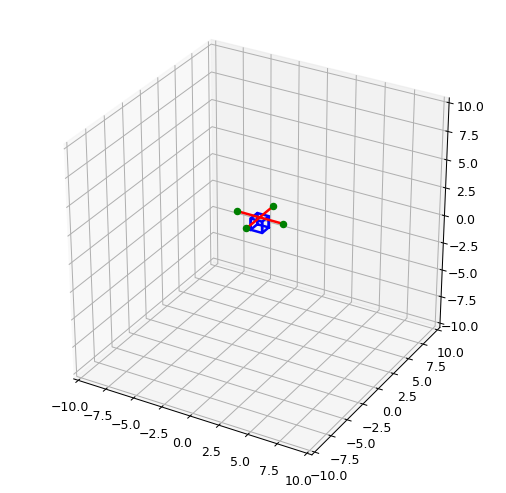

In [ ]:
# animation block does not change

# base of the quad
w = 2

v1=np.array([-w/4, -w/4, w/2]).T
v2=np.array([-w/4, -w/4, 0]).T
v3=np.array([w/4, -w/4, 0]).T
v4=np.array([w/4, -w/4, w/2]).T

v5=np.array([w/4, w/4, w/2]).T
v6=np.array([w/4, w/4, 0]).T
v7=np.array([-w/4, w/4, 0]).T
v8=np.array([-w/4, w/4, w/2]).T

# arms of the quad

a1 = np.array([w, 0, 0]).T
a2 = np.array([-w, 0, 0]).T
a3 = np.array([0, w, 0]).T
a4 = np.array([0, -w, 0]).T



pos_ned = np.array([pn, pe, pd]).T


R = rotation_matrix_body2Inertial(phi,theta,psi)


#arm rotation
a1r=np.matmul(R,a1)+pos_ned
a2r=np.matmul(R,a2)+pos_ned
a3r=np.matmul(R,a3)+pos_ned
a4r=np.matmul(R,a4)+pos_ned

# rendering matrix for arms
R_plot = rotation_matrix_plot_rendering()
A1r = np.matmul(R_plot, a1r)
A2r = np.matmul(R_plot, a2r)
A3r = np.matmul(R_plot, a3r)
A4r = np.matmul(R_plot, a4r)
#arm 1 points
arm1_x = [A1r[0], A2r[0]]
arm1_y = [A1r[1], A2r[1]]
arm1_z = [A1r[2], A2r[2]]

#arm 2 points

arm2_x = [A3r[0], A4r[0]]
arm2_y = [A3r[1], A4r[1]]
arm2_z = [A3r[2], A4r[2]]

# rotor co ords
rot_x= [A1r[0], A2r[0], A3r[0], A4r[0]]
rot_y= [A1r[1], A2r[1], A3r[1], A4r[1]]
rot_z= [A1r[2], A2r[2], A3r[2], A4r[2]]


#cube faces rotation
v1r=np.matmul(R,v1)+pos_ned
v2r=np.matmul(R,v2)+pos_ned
v3r=np.matmul(R,v3)+pos_ned
v4r=np.matmul(R,v4)+pos_ned
v5r=np.matmul(R,v5)+pos_ned
v6r=np.matmul(R,v6)+pos_ned
v7r=np.matmul(R,v7)+pos_ned
v8r=np.matmul(R,v8)+pos_ned

#rendering matrix for box
v1r=np.matmul(R_plot, v1r)
v2r=np.matmul(R_plot, v2r)
v3r=np.matmul(R_plot, v3r)
v4r=np.matmul(R_plot, v4r)
v5r=np.matmul(R_plot, v5r)
v6r=np.matmul(R_plot, v6r)
v7r=np.matmul(R_plot, v7r)
v8r=np.matmul(R_plot, v8r)


f1_x=[v1r[0], v2r[0], v3r[0], v4r[0], v1r[0]]
f1_y=[v1r[1], v2r[1], v3r[1], v4r[1], v1r[1]]
f1_z=[v1r[2], v2r[2], v3r[2], v4r[2], v1r[2]]
f2_x=[v5r[0], v6r[0], v7r[0], v8r[0], v5r[0]]
f2_y=[v5r[1], v6r[1], v7r[1], v8r[1], v5r[1]]
f2_z=[v5r[2], v6r[2], v7r[2], v8r[2], v5r[2]]
f3_x=[v4r[0], v5r[0], v6r[0], v3r[0], v4r[0]]
f3_y=[v4r[1], v5r[1], v6r[1], v3r[1], v4r[1]]
f3_z=[v4r[2], v5r[2], v6r[2], v3r[2], v4r[2]]
f4_x=[v1r[0], v8r[0], v7r[0], v2r[0], v1r[0]]
f4_y=[v1r[1], v8r[1], v7r[1], v2r[1], v1r[1]]
f4_z=[v1r[2], v8r[2], v7r[2], v2r[2], v1r[2]]



pn_data.append(states[0])
pe_data.append(states[1])
h_data.append(-states[2])
u_data.append(states[3])
v_data.append(states[4])
w_data.append(states[5])
phi_data.append(states[6])
theta_data.append(states[7])
psi_data.append(states[8])
p_data.append(states[9])
q_data.append(states[10])
r_data.append(states[11])

fig = plt.figure(figsize=(7,7),dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(( -10, 10))
ax.set_ylim((-10, 10))
ax.set_zlim((-10, 10))


#face handles for the quadbase
face1, = ax.plot(f1_x, f1_y, f1_z, 'b', lw=2)
face2, = ax.plot(f2_x, f2_y, f2_z, 'b', lw=2)
face3, = ax.plot(f3_x, f3_y, f3_z, 'b', lw=2)
face4, = ax.plot(f4_x, f4_y, f4_z, 'b', lw=2)

arm1, =  ax.plot(arm1_x, arm1_y, arm1_z,'r-', lw=2)
arm2, = ax.plot(arm2_x, arm2_y, arm2_z, 'r-', lw=2 )
rotor, = ax.plot(rot_x, rot_y, rot_z, 'go', markersize=5)

traj, = ax.plot(pe_data, pn_data, h_data, 'b:', lw=2)
reference_traj, = ax.plot(pe_n_data, pn_n_data, pd_n_data, 'g-', lw=1)
#veh_n, = ax.plot(veh_nx, veh_ny, veh_nz, 'r', lw=2)
#veh_e, = ax.plot(veh_ex, veh_ey, veh_ez, 'g', lw=2)
#veh_d, = ax.plot(veh_dx, veh_dy, veh_dz, 'b', lw=2)

Quadrotor dynamics

In [ ]:
def quad_dynamics(t, y, F, tau_phi, tau_theta, tau_psi):

    # states
    #pose
    pn = y[0]
    pe = y[1]
    pd = y[2]
    #linear velocities
    u = y[3]
    v = y[4]
    w = y[5]
    #euler angles
    phi = y[6]
    theta = y[7]
    psi = y[8]
    # angular velocities
    p = y[9]
    q = y[10]
    r = y[11]

    lin_vel = np.array([u, v, w]).T
    ang_vel = np.array([p, q, r]).T
    R_b_w = rotation_matrix_body2Inertial(phi, theta, psi)

    # thrust forces
    Thrust = np.array([0, 0, -F/m]).T
    R_w_b = R_b_w.T

    #gravity
    gravity = np.array([0, 0, g]).T


    # pn dot, pe dot, pd dot : linear velocities
    pndot = u
    pedot = v
    pddot = w

    # u dot, v dot, wdot : accelerations
    Linv_dot = np.matmul(R_b_w, Thrust) + gravity
    udot = Linv_dot[0]
    vdot = Linv_dot[1]
    wdot = Linv_dot[2]


    # angular velocities
    G = gyro2body(phi, theta)

    Euler_dot = np.matmul(G, ang_vel)

    phidot = Euler_dot[0]
    thetadot = Euler_dot[1]
    psidot = Euler_dot[2]

    # equation4 [pdot, qdot, rdot] = J1 * [temp* J2 * angvel] + Tau

    pdot = q * r * (Jy - Jz) / Jx + (1/Jx) * tau_phi
    qdot = p * r * (Jz - Jx) / Jy + (1/Jy) * tau_theta
    rdot = p * q * (Jx - Jy) / Jz + (1/Jz) * tau_psi



    return [pndot, pedot, pddot, udot, vdot, wdot, phidot, thetadot, psidot, pdot, qdot, rdot]

In [ ]:
# y trajectory
def trajectory(i):
    # y reference - y_r
    # case 1
    a = 1.5
    b = 0.75
    c = 0
    n = -0.75
    T1 = 5
    w1 = 2 * np.pi/T1
    w2 = w1/2
    w3 = w1

    # case 2
    # a = 1.5
    # b = 0.75
    # c = 0.5
    # n = -0.75
    # T1 = 10
    # w1 = 2 * np.pi/T1
    # w2 = w1/2
    # w3 = w1

    # case 3
    # a = 0.75
    # b = 0.75
    # c = 0
    # n = -0.75
    # T1 = 10
    # w1 = 2 * np.pi/T1
    # w2 = w1
    # w3 = w1

    # case 4
    # a = 1.5
    # b = 0.75
    # c = 0
    # n = -0.75
    # T1 = 5
    # w1 = 2 * np.pi/T1
    # w2 = w1/2
    # w3 = w1

    # case 5 : own trajectory  - spiral
    # a = 1.5
    # b = 1.5
    # c = 0
    # n = -0.75 * i
    # T1 = 5
    # w1 = 2 * np.pi/T1
    # w2 = w1
    # w3 = w2

    y_r = np.array([a * np.cos(w2*i), b * np.sin(w1*i), n + c * np.sin(w3*i), np.pi/4 ])

    y_rdot = np.array([-a*w2*np.sin(w2*i), b*w1*np.cos(w1*i), c*w3*np.cos(w3*i), 0])

    y_rddot = np.array([-a* w2 *w2 * np.cos(w2*i), -b * w1 * w1 * np.sin(w1*i), -c * w3 * w3 * np.sin(w3*i), 0])

    u_r = np.array([y_rddot[0] , y_rddot[1], y_rddot[2] - g, y_rddot[3]])

    # x_reference

    x_r = np.array([[y_r[0]], [y_r[1]], [y_r[2]], [y_rdot[0]], [y_rdot[1]], [y_rdot[2]], [y_r[3]]])

    pn_n_data.append(-y_r[0])
    pe_n_data.append(-y_r[1])
    pd_n_data.append(-y_r[2])
    u_n_data.append(y_rdot[0])
    v_n_data.append(y_rdot[1])
    w_n_data.append(y_rdot[2])
    psi_n_data.append(y_r[3])

    return u_r, x_r

Attitude controller blocks for phi, theta and psi



In [ ]:
def attitude_controller_phi(error_a, K1):
    u_phi = - K1[0,0]*error_a[0]- K1[0,1]*error_a[1] - K1[0,2]*error_a[2] - K1[0,3]*error_a[3]- K1[0,4]*error_a[4]
    return u_phi


In [ ]:
def attitude_controller_theta(error_a, K1):
    u_theta = - K1[1,0]*error_a[0] - K1[1,1]*error_a[1] - K1[1,2]*error_a[2] - K1[1,3]*error_a[3] - K1[1,4]*error_a[4]
    return u_theta

In [ ]:
def attitude_controller_psi(error_a, K1):
   u_psi = -K1[2,0]*error_a[0] - K1[2,1]*error_a[1] - K1[2,2]*error_a[2] - K1[2,3]*error_a[3] - K1[2,4]*error_a[4]
   return u_psi

In [ ]:
def traj_control(states, u_ref, x_ref, K):
  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  #7 state system
  diff_states=np.array([[pn], [pe], [pd], [u], [v], [w], [psi]])

  # X~ = true states - reference states
  del_x = diff_states-x_ref

  # input error U~ = - K * (X~)
  del_u = -np.matmul(K,del_x)

  # total input = U~ + reference input
  u_c = del_u + u_ref

  up = np.array([u_c[0,0], u_c[1,0], u_c[2,0]])

  # Commanded inputs Td, Phi_d, Theta_d, Psi_d from inverse mapping

  Td = m*np.sqrt(np.matmul(up.transpose(), up))

  R_psi = np.array([[np.cos(psi), np.sin(psi), 0],
                    [-np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])
  z = -np.matmul(R_psi, up)*m/Td

  phi_d = np.arcsin(-z[1])
  theta_d = np.arctan2(z[0], z[2])
  r_d = u_c[3,0]*cos(phi)*cos(theta)-q*sin(phi)

  error_pn.append(-del_x[0])
  error_pe.append(-del_x[1])
  error_pd.append(-del_x[2])
  error_U.append(-del_x[3])
  error_V.append(-del_x[4])
  error_W.append(-del_x[5])
  error_psi.append(-del_x[6])


  return Td, float(phi_d), float(theta_d) , float(r_d)

Function for solving the state equations

In [ ]:
def step(states, dt, i):
    pn = states[0]
    pe = states[1]
    pd = states[2]

    u = states[3]
    v = states[4]
    w = states[5]

    phi = states[6]
    theta = states[7]
    psi = states[8]

    p = states[9]
    q = states[10]
    r = states[11]

    u_ref, x_ref = trajectory(i/15)

    Td, phid, thetad, rd = traj_control(states, u_ref, x_ref, K)

   # errors - attitude controller inputs ( true states - commanded angles)
    e_phi = phi - phid
    e_theta = theta - thetad
    e_r =  r - rd

    # plotting commanded angles
    phid_data.append(phid)
    thetad_data.append(thetad)
    psid_data.append(rd)


    # state vector for attitude controller : x1 = ephi , x2 = phidot, x3 = etheta, x4 = thetadot, x5 = e_r
    states_attitude = np.array([e_phi, p, e_theta, q, e_r])


    tau_phi = attitude_controller_phi(states_attitude, K1)
    tau_theta = attitude_controller_theta(states_attitude, K1)
    tau_psi = attitude_controller_psi(states_attitude, K1)

    sol = solve_ivp(lambda t, y: quad_dynamics(t, y, Td, tau_phi, tau_theta, tau_psi), [0, dt], [pn, pe, pd, u, v, w, phi, theta, psi, p, q, r], t_eval=np.linspace( 0, dt, 10))
    states = sol.y[:,-1].T

    # error plot data
    error_phi.append(e_phi)
    error_theta.append(e_theta)
    error_r.append(e_r)

    return states


Function to update the vertices and co ordinates


In [ ]:
# draw file
def update_vertices(i):
    global states
    states = step(states, dt, i)

    pn = states[0]
    pe = states[1]
    pd = states[2]

    u = states[3]
    v = states[4]
    w = states[5]

    phi = states[6]
    theta = states[7]
    psi = states[8]

    p = states[9]
    q = states[10]
    r = states[11]


    pos_ned = np.array([pn, pe, pd]).T
    R = rotation_matrix_body2Inertial(phi,theta,psi)


    #arm rotation
    a1r=np.matmul(R,a1)+pos_ned
    a2r=np.matmul(R,a2)+pos_ned
    a3r=np.matmul(R,a3)+pos_ned
    a4r=np.matmul(R,a4)+pos_ned

    # rendering matrix for arms
    R_plot = rotation_matrix_plot_rendering()
    A1r = np.matmul(R_plot, a1r)
    A2r = np.matmul(R_plot, a2r)
    A3r = np.matmul(R_plot, a3r)
    A4r = np.matmul(R_plot, a4r)
    #arm 1 points
    arm1_x = [A1r[0], A2r[0]]
    arm1_y = [A1r[1], A2r[1]]
    arm1_z = [A1r[2], A2r[2]]

    #arm 2 points

    arm2_x = [A3r[0], A4r[0]]
    arm2_y = [A3r[1], A4r[1]]
    arm2_z = [A3r[2], A4r[2]]

    # rotor co ords
    rot_x= [A1r[0], A2r[0], A3r[0], A4r[0]]
    rot_y= [A1r[1], A2r[1], A3r[1], A4r[1]]
    rot_z= [A1r[2], A2r[2], A3r[2], A4r[2]]

    #cube faces rotation
    v1r=np.matmul(R,v1)+pos_ned
    v2r=np.matmul(R,v2)+pos_ned
    v3r=np.matmul(R,v3)+pos_ned
    v4r=np.matmul(R,v4)+pos_ned
    v5r=np.matmul(R,v5)+pos_ned
    v6r=np.matmul(R,v6)+pos_ned
    v7r=np.matmul(R,v7)+pos_ned
    v8r=np.matmul(R,v8)+pos_ned

    #rendering matrix for box
    v1r=np.matmul(R_plot, v1r)
    v2r=np.matmul(R_plot, v2r)
    v3r=np.matmul(R_plot, v3r)
    v4r=np.matmul(R_plot, v4r)
    v5r=np.matmul(R_plot, v5r)
    v6r=np.matmul(R_plot, v6r)
    v7r=np.matmul(R_plot, v7r)
    v8r=np.matmul(R_plot, v8r)


    f1_x=[v1r[0], v2r[0], v3r[0], v4r[0], v1r[0]]
    f1_y=[v1r[1], v2r[1], v3r[1], v4r[1], v1r[1]]
    f1_z=[v1r[2], v2r[2], v3r[2], v4r[2], v1r[2]]
    f2_x=[v5r[0], v6r[0], v7r[0], v8r[0], v5r[0]]
    f2_y=[v5r[1], v6r[1], v7r[1], v8r[1], v5r[1]]
    f2_z=[v5r[2], v6r[2], v7r[2], v8r[2], v5r[2]]
    f3_x=[v4r[0], v5r[0], v6r[0], v3r[0], v4r[0]]
    f3_y=[v4r[1], v5r[1], v6r[1], v3r[1], v4r[1]]
    f3_z=[v4r[2], v5r[2], v6r[2], v3r[2], v4r[2]]
    f4_x=[v1r[0], v8r[0], v7r[0], v2r[0], v1r[0]]
    f4_y=[v1r[1], v8r[1], v7r[1], v2r[1], v1r[1]]
    f4_z=[v1r[2], v8r[2], v7r[2], v2r[2], v1r[2]]

    pn_data.append(states[0])
    pe_data.append(states[1])
    h_data.append(-states[2])
    u_data.append(states[3])
    v_data.append(states[4])
    w_data.append(states[5])
    phi_data.append(states[6])
    theta_data.append(states[7])
    psi_data.append(states[8])
    p_data.append(states[9])
    q_data.append(states[10])
    r_data.append(states[11])


    #use set data


    face1.set_data(f1_x, f1_y)
    face1.set_3d_properties(f1_z)
    face2.set_data(f2_x, f2_y)
    face2.set_3d_properties(f2_z)
    face3.set_data(f3_x, f3_y)
    face3.set_3d_properties(f3_z)
    face4.set_data(f4_x, f4_y)
    face4.set_3d_properties(f4_z)

    arm1.set_data(arm1_x, arm1_y)
    arm1.set_3d_properties(arm1_z)
    arm2.set_data(arm2_x, arm2_y)
    arm2.set_3d_properties(arm2_z)
    rotor.set_data(rot_x, rot_y)
    rotor.set_3d_properties(rot_z)

    traj.set_data(pe_data, pn_data)
    traj.set_3d_properties(h_data)

    #reference trajectory
    reference_traj.set_data(pe_n_data, pn_n_data)
    reference_traj.set_3d_properties(pd_n_data)


    return (face1, face2, face3, face4, arm1, arm2, rotor, traj, reference_traj)

In [ ]:
def stateplots(i):
    global states
    pn = states[0]
    pe = states[1]
    pd = states[2]

    u = states[3]
    v = states[4]
    w = states[5]

    phi = states[6]
    theta = states[7]
    psi = states[8]

    p = states[9]
    q = states[10]
    r = states[11]


    pn_data.append(states[0])
    pe_data.append(states[1])
    h_data.append(-states[2])
    u_data.append(states[3])
    v_data.append(states[4])
    w_data.append(states[5])
    phi_data.append(states[6])
    theta_data.append(states[7])
    psi_data.append(states[8])
    p_data.append(states[9])
    q_data.append(states[10])
    r_data.append(states[11])

    return pn_data, pe_data, h_data, u_data, v_data, w_data, phi_data, theta_data, psi_data, p_data, q_data, r_data

Animation


In [ ]:
from matplotlib import animation
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Differential flatness Based Control: spiral path green(ref), blue(actual)')


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, update_vertices, frames=frames, interval=30, blit=True)

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

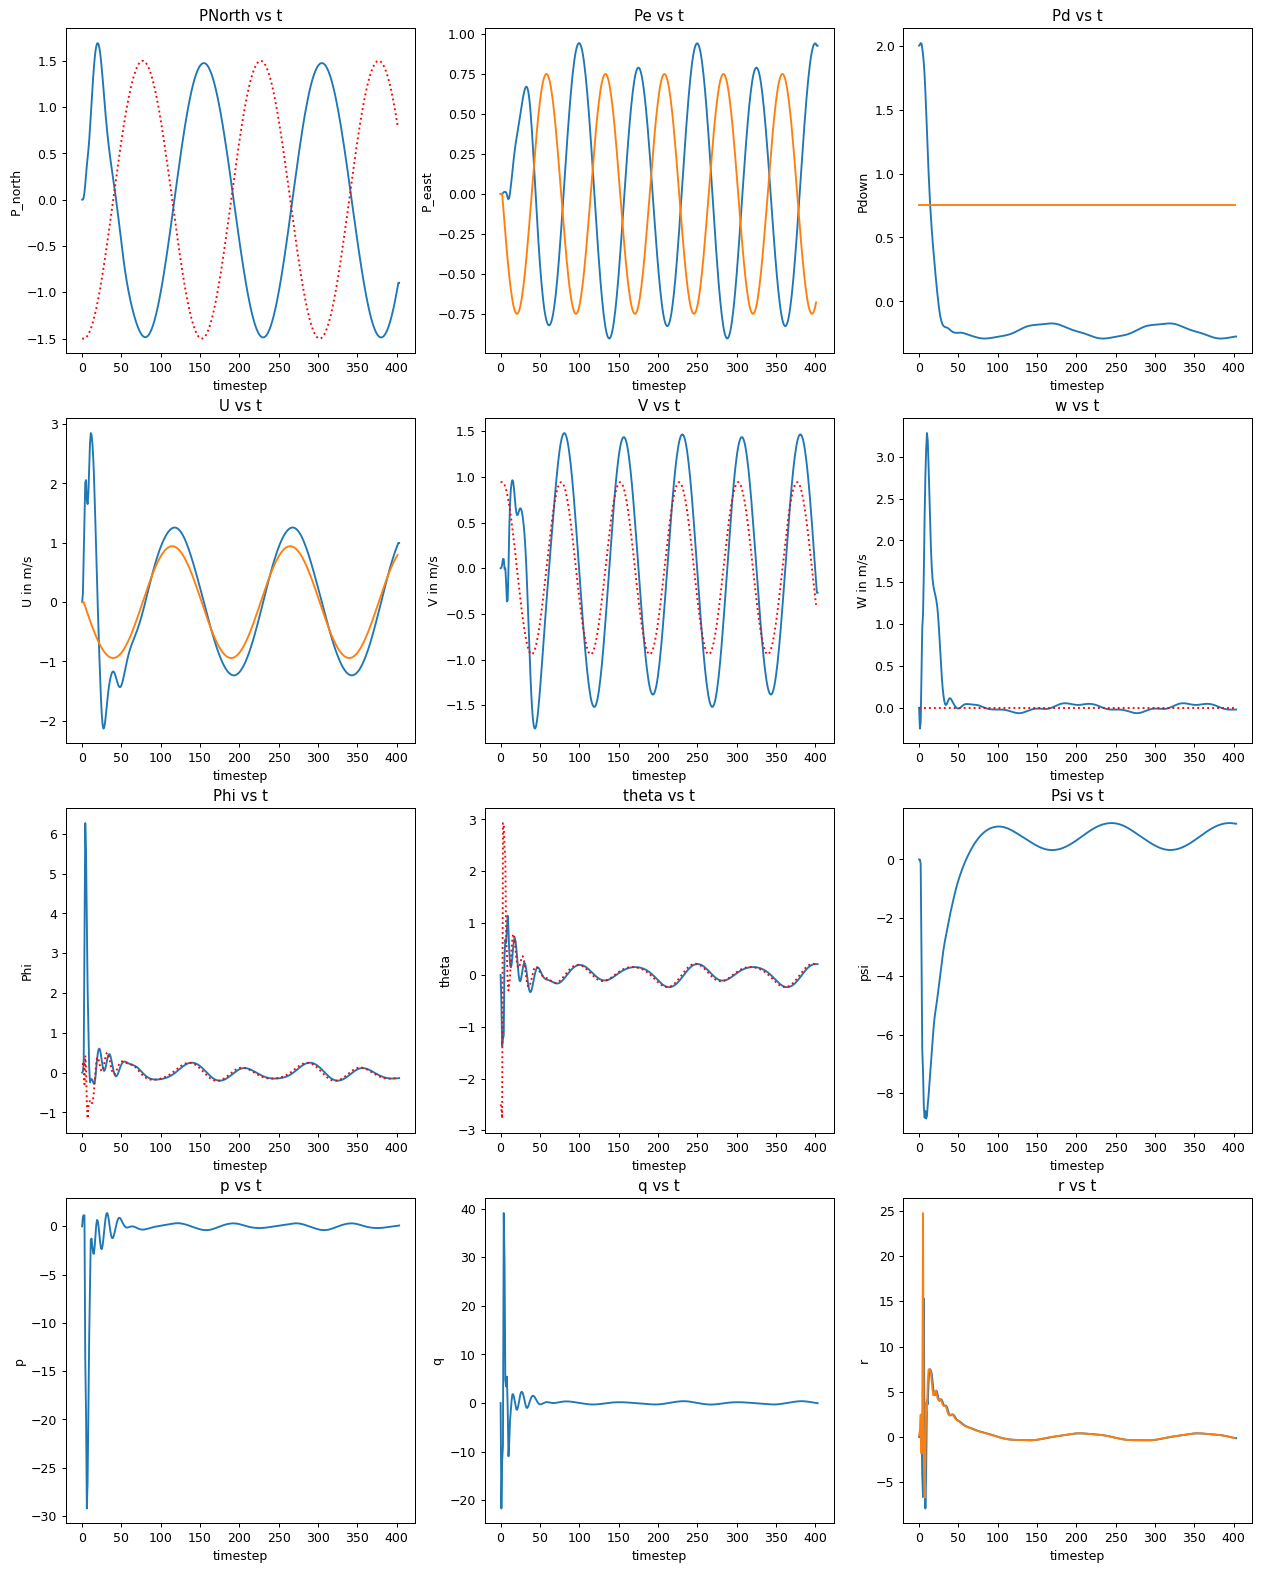

In [ ]:
pn_data1, pe_data1, h_data1, u_data1, v_data1, w_data1, phi_data1, theta_data1, psi_data1, p_data1, q_data1, r_data1 = stateplots(10)

fig1 = plt.figure(figsize=(17,22), dpi=90)
ax1 = fig1.add_subplot(4, 3, 1)
ax1.set_xlabel('timestep')
ax1.set_ylabel('P_north')
ax1.set_title('PNorth vs t')
PN1 = ax1.plot(range(len(pn_data1)), pn_data1)
PN11 = ax1.plot(range(len(pn_n_data)), pn_n_data,'r:')

ax2 = fig1.add_subplot(4, 3, 2)
ax2.set_xlabel('timestep')
ax2.set_ylabel('P_east')
ax2.set_title('Pe vs t')
PN2 = ax2.plot(range(len(pe_data1)), pe_data1)
PN22 = ax2.plot(range(len(pe_n_data)), pe_n_data)

ax3 = fig1.add_subplot(4, 3, 3)
ax3.set_xlabel('timestep')
ax3.set_ylabel('Pdown')
ax3.set_title('Pd vs t')
PN3 = ax3.plot(range(len(h_data1)), h_data1)
PN33 = ax3.plot(range(len(pd_n_data)), pd_n_data)

ax4 = fig1.add_subplot(4, 3, 4)
ax4.set_xlabel('timestep')
ax4.set_ylabel('U in m/s')
ax4.set_title('U vs t')
U = ax4.plot(range(len(u_data1)), u_data1)
U1 = ax4.plot(range(len(u_n_data)), u_n_data)

ax5 = fig1.add_subplot(4, 3, 5)
ax5.set_xlabel('timestep')
ax5.set_ylabel('V in m/s')
ax5.set_title('V vs t')
V = ax5.plot(range(len(v_data1)), v_data1)
V1 = ax5.plot(range(len(v_n_data)), v_n_data,'r:')

ax6 = fig1.add_subplot(4, 3, 6)
ax6.set_xlabel('timestep')
ax6.set_ylabel('W in m/s')
ax6.set_title('w vs t')
W = ax6.plot(range(len(w_data1)), w_data1)
W1 = ax6.plot(range(len(w_n_data)), w_n_data,'r:')

ax7 = fig1.add_subplot(4, 3, 7)
ax7.set_xlabel('timestep')
ax7.set_ylabel('Phi')
ax7.set_title('Phi vs t')
PHI = ax7.plot(range(len(phi_data1)), phi_data1)
PHIC = ax7.plot(range(len(phid_data)), phid_data, 'r:')

ax8 = fig1.add_subplot(4, 3, 8)
ax8.set_xlabel('timestep')
ax8.set_ylabel('theta')
ax8.set_title('theta vs t')
THETA = ax8.plot(range(len(theta_data1)), theta_data1)
THETAC = ax8.plot(range(len(thetad_data)), thetad_data, 'r:')

ax9 = fig1.add_subplot(4, 3, 9)
ax9.set_xlabel('timestep')
ax9.set_ylabel('psi')
ax9.set_title('Psi vs t')
PSI = ax9.plot(range(len(psi_data1)), psi_data1)
#PSIC = ax9.plot(range(len(psic_data)), psic_data, 'r:')

ax10 = fig1.add_subplot(4, 3, 10)
ax10.set_xlabel('timestep')
ax10.set_ylabel('p')
ax10.set_title('p vs t')
P_data = ax10.plot(range(len(p_data1)), p_data1)

ax11 = fig1.add_subplot(4, 3, 11)
ax11.set_xlabel('timestep')
ax11.set_ylabel('q')
ax11.set_title('q vs t')
Q_data = ax11.plot(range(len(q_data1)), q_data1)

ax12 = fig1.add_subplot(4, 3, 12)
ax12.set_xlabel('timestep')
ax12.set_ylabel('r')
ax12.set_title('r vs t')
R_data = ax12.plot(range(len(r_data1)), r_data1)
Rc_data = ax12.plot(range(len(psid_data)), psid_data)

In [ ]:
## error states vs time plots
fig2 = plt.figure(figsize=(15,25))

ax1 = fig2.add_subplot(5, 2, 1)
ax1.set_xlabel('timestep')
ax1.set_ylabel('Error Pn')
ax1.set_title('Pn_error vs t')
PN1 = ax1.plot(range(len(error_pn)), error_pn)

ax2 = fig2.add_subplot(5, 2, 2)
ax2.set_xlabel('timestep')
ax2.set_ylabel('Error Pe')
ax2.set_title('Pe_error vs time')
PE1 = ax2.plot(range(len(error_pe)),error_pe)


ax3 = fig2.add_subplot(5, 2, 3)
ax3.set_xlabel('timestep')
ax3.set_ylabel('Pd Error')
ax3.set_title('Pd_error vs time')
h1 = ax3.plot(range(len(error_pd)),error_pd)

ax4 = fig2.add_subplot(5, 2, 4)
ax4.set_xlabel('timestep')
ax4.set_ylabel('Vn Error')
ax4.set_title('Error_U vs time')
vn1 = ax4.plot(range(len(error_U)),error_U)

ax5 = fig2.add_subplot(5, 2, 5)
ax5.set_xlabel('Time Step')
ax5.set_ylabel('V Error ')
ax5.set_title('Error_V vs time')
ve1 = ax5.plot(range(len(error_V)),error_V)

ax6 = fig2.add_subplot(5, 2, 6)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('W Error')
ax6.set_title('Error _w vs time')
vd1 = ax6.plot(range(len(error_W)),error_W)

ax7 = fig2.add_subplot(5, 2, 7)
ax7.set_xlabel('Time ')
ax7.set_ylabel('Psi Error')
ax7.set_title('Error Plot of Psi')
psi1 = ax7.plot(range(len(error_psi)),error_psi)

ax8 = fig2.add_subplot(5, 2, 8)
ax8.set_xlabel('Time ')
ax8.set_ylabel('Phi Error')
ax8.set_title('Error in Phi vs time')
phi1 = ax8.plot(range(len(error_phi)),error_phi)

ax9 = fig2.add_subplot(5, 2, 9)
ax9.set_xlabel('Time ')
ax9.set_ylabel('Theta_error')
ax9.set_title('Error in Theta vs time')
theta1 = ax9.plot(range(len(error_theta)),error_theta)

ax10 = fig2.add_subplot(5, 2, 10)
ax10.set_xlabel('Time ')
ax10.set_ylabel('r_error')
ax10.set_title('Error Plot of r vs time')
r1 = ax10.plot(range(len(error_r)),error_r)
